In [1]:
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('../src')

from data import *
from model import *
from train import *
import random

ROOT = Path("..").resolve()
tng_base_path = f"{ROOT}/illustris_data/TNG50-1/output"

seed = 255
rng = np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)

c0, c1, c2, c3, c4 = '#003f5c', '#58508d', '#bc5090', '#ff6361', '#ffa600'

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


# Predict halo mass

In [2]:
# predict outputs: log_halo_mass, vmax, both
science_params = dict(
    minimum_log_stellar_mass=7.5,  
    minimum_log_halo_mass=8.0, 
    predict_output="log_halo_mass",
)

experiment = science_params["predict_output"]


config_params = dict(
    boxsize=51.7e3,    # box size in comoving kpc/h
    h_reduced=0.704,   # reduced Hubble constant
    snapshot=99,       # z = 0
)

normalization_params = dict(
    minimum_n_star_particles=10., # min star particles to be considered a galaxy
    norm_half_mass_radius=3., 
    norm_velocity=100., # note: use value of 1 if `use_central_galaxy_frame=True`
)

feature_params = dict(
    use_stellarhalfmassradius=False,
    use_velocity=True,
    use_only_positions=False,
    use_central_galaxy_frame=False, # otherwise use center of mass frame
    in_projection=True, # only use projected positions and radial velocity
)

training_params = dict(
    batch_size=256,
    learning_rate=1e-4,
    weight_decay=1e-5,
    n_epochs=300,
    valid_frac=0.15, 
    test_frac=0., 
)

model_params = dict(
    k_nn=100,
    n_layers=1,  
    n_hidden=128,
    n_latent=96,
    n_out=2 if experiment == "both" else 1,
    loop=False
)


print(f'Experiment: predicting {experiment}')
print(f'stellar mass cut: log(M* / Msun) > {science_params["minimum_log_stellar_mass"]:g}')
print(f'Feature params:', feature_params)

Experiment: predicting log_halo_mass
stellar mass cut: log(M* / Msun) > 7.5
Feature params: {'use_stellarhalfmassradius': False, 'use_velocity': True, 'use_only_positions': False, 'use_central_galaxy_frame': False, 'in_projection': True}


In [3]:
# df = load_data(
#     tng_base_path=tng_base_path,
#     snapshot=config_params["snapshot"], # default is 99 -> z=0 
#     use_stellarhalfmassradius=feature_params["use_stellarhalfmassradius"],
#     use_velocity=feature_params["use_velocity"],
#     use_only_positions=feature_params["use_only_positions"],
#     in_projection=feature_params["in_projection"],
#     science_params=science_params
# )

# dataset, n_subhalos = generate_dataset(
#     df,
#     use_velocity=feature_params["use_velocity"],
#     use_only_positions=feature_params["use_only_positions"],
#     in_projection=feature_params["in_projection"],
#     use_stellarhalfmassradius=feature_params["use_stellarhalfmassradius"],
#     science_params=science_params
# )
# torch.save(dataset, f"{ROOT}/results/{experiment}/dataset.pth")
 

Number of features: 4
Number of subhalos: 2831
Number of halos: 533


In [11]:
dataset = torch.load(f"{ROOT}/results/{experiment}/dataset.pth")

node_features = dataset[0].x.shape[1]
n_halos = len(dataset)

print("Number of features:", node_features)
print("Number of subhalos:", n_subhalos)
print("Number of halos:", n_halos)

In [4]:
train_loader, valid_loader, test_loader = split_datasets(
    dataset,
    rng=rng,
    valid_frac=training_params["valid_frac"],
    test_frac=training_params["test_frac"],
    batch_size=training_params["batch_size"],
)

print("Number of training batches", len(train_loader))
print("Number of valication batches", len(valid_loader))
print("Number of test batches", len(test_loader))

Number of training batches 2
Number of valication batches 1
Number of test batches 0


In [5]:
model = EdgePointGNN(
    node_features=node_features, 
    n_layers=model_params["n_layers"], 
    n_out=model_params["n_out"],
    k_nn=model_params["k_nn"],
    hidden_channels=model_params["n_hidden"],
    latent_channels=model_params["n_latent"],
    loop=model_params["loop"],
    estimate_all_subhalos=True
)

model.to(device)

EdgePointGNN(
  (layers): ModuleList(
    (0): EdgePointLayer()
  )
  (fc): Sequential(
    (0): Linear(in_features=96, out_features=96, bias=True)
    (1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=96, out_features=96, bias=True)
    (4): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=96, out_features=2, bias=True)
  )
)

In [6]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=training_params["learning_rate"], 
    weight_decay=training_params["weight_decay"]
)

In [7]:
train_losses = []
valid_losses = []
for epoch in range(training_params["n_epochs"]):
    train_loss = train(train_loader, model, optimizer, device, in_projection=feature_params["in_projection"])
    valid_loss, valid_std, *_ = validate(valid_loader, model, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1: >3d}    train loss: {train_loss: >4.1f}     valid loss: {valid_loss: >4.1f}     average valid std: {np.mean(valid_std): >5.3f}")


Epoch  10    train loss: -1.1     valid loss: -1.2     average valid std: 0.480
Epoch  20    train loss: -2.3     valid loss: -2.2     average valid std: 0.335
Epoch  30    train loss: -2.9     valid loss: -2.6     average valid std: 0.302
Epoch  40    train loss: -3.1     valid loss: -2.8     average valid std: 0.267
Epoch  50    train loss: -3.2     valid loss: -3.0     average valid std: 0.245
Epoch  60    train loss: -3.3     valid loss: -3.0     average valid std: 0.231
Epoch  70    train loss: -3.4     valid loss: -3.1     average valid std: 0.217
Epoch  80    train loss: -3.3     valid loss: -3.1     average valid std: 0.207
Epoch  90    train loss: -3.4     valid loss: -3.2     average valid std: 0.201
Epoch 100    train loss: -3.4     valid loss: -3.2     average valid std: 0.195
Epoch 110    train loss: -3.4     valid loss: -3.2     average valid std: 0.187
Epoch 120    train loss: -3.4     valid loss: -3.2     average valid std: 0.182
Epoch 130    train loss: -3.5     valid 

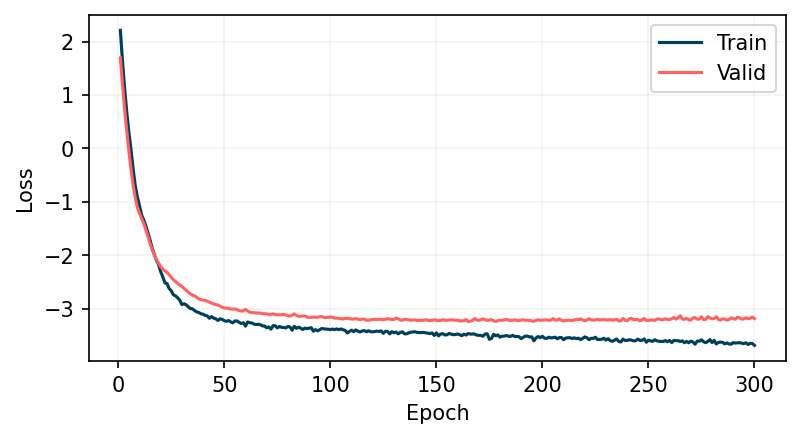

In [8]:
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(1 + np.arange(training_params["n_epochs"]), train_losses, c=c0, label="Train")
plt.plot(1 + np.arange(training_params["n_epochs"]), valid_losses, c=c3, label="Valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.15)

In [9]:
valid_loss, valid_std, p_valid, y_valid, logvar_valid = validate(valid_loader, model, device)

print(f"Valid RMSE: {np.sqrt(np.mean((y_valid.flatten() - p_valid)**2)): >4.3f}")
print(f"Valid loss: {valid_loss: >4.3f}")
print(f"Valid std: {valid_std.item(): >6.4f}")

Valid RMSE: 0.452
Valid loss: -3.184
Valid std: 0.1388


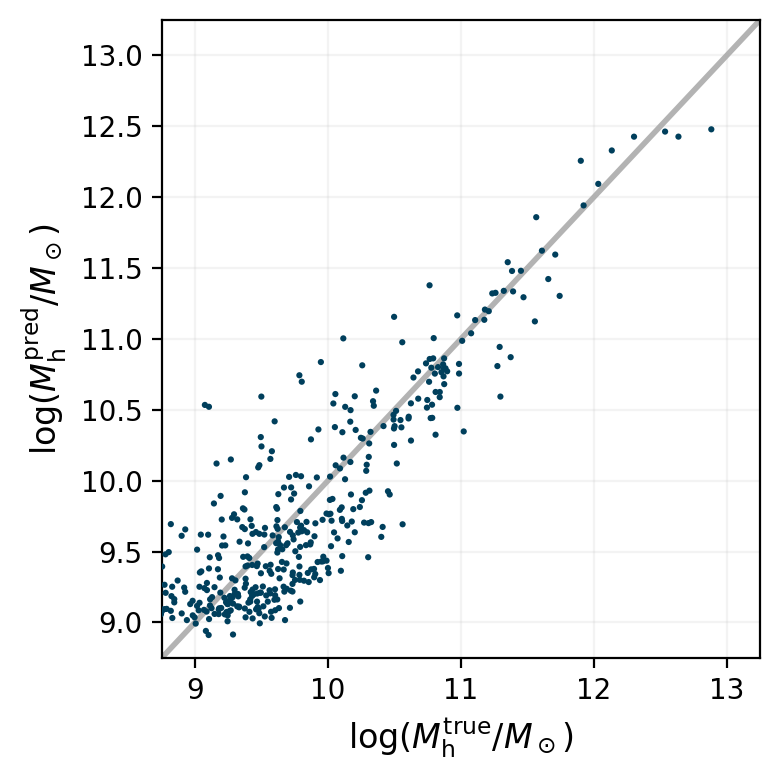

In [10]:
plt.figure(figsize=(4, 4), dpi=200)

h = config_params["h_reduced"]
p = p_valid + 10 - h
y = y_valid + 10 - h

plt.scatter(y, p, s=5, edgecolors='none', c="#003f5c", zorder=3)

plt.xlabel("$\\log(M_{\\rm h}^{\\rm true}/M_\\odot)$", fontsize=12)
plt.ylabel("$\\log(M_{\\rm h}^{\\rm pred}/M_\\odot)$", fontsize=12)
plt.plot([8.75, 13.25], [8.75, 13.25], c='0.7', lw=2, zorder=1)

plt.xlim(8.75, 13.25)
plt.ylim(8.75, 13.25)
plt.tight_layout()
plt.grid(alpha=0.15)

## Baseline: Predict Mhalo directly from stellar mass

Text(0, 0.5, '$\\log(M_{\\bigstar}/M_\\odot)$')

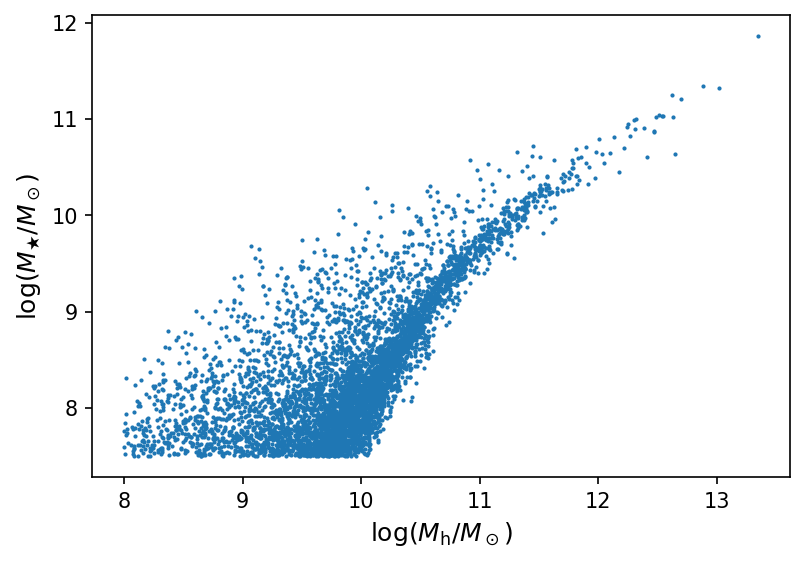

In [12]:
x = df.subhalo_logstellarmass
y = df.subhalo_halomass.apply(np.log10)

plt.figure(figsize=(6, 4), dpi=150)
plt.scatter(y + 10 - h, x + 10 - h, s=1)
plt.xlabel("$\\log(M_{\\rm h}/M_\\odot)$", fontsize=12)
plt.ylabel("$\\log(M_{\\bigstar}/M_\\odot)$", fontsize=12)

In [16]:
import sklearn.model_selection
import sklearn.ensemble

In [39]:
X = torch.cat([d.x[:, -1] for d in dataset]).numpy()
y = torch.cat([d.y[:,0] for d in dataset]).numpy()

is_finite = (np.isfinite(X) & np.isfinite(y))

X = X[is_finite].reshape(-1, 1)
y = y[is_finite]

In [40]:
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

In [41]:
rf = sklearn.ensemble.RandomForestRegressor()

rf.fit(X_train, y_train)
p_valid = rf.predict(X_valid)

In [42]:
np.mean((p_valid - y_valid)**2)**0.5

0.9485437282272318

Text(0, 0.5, '$\\log(M_{\\rm h}/M_\\odot)^{\\rm pred}$')

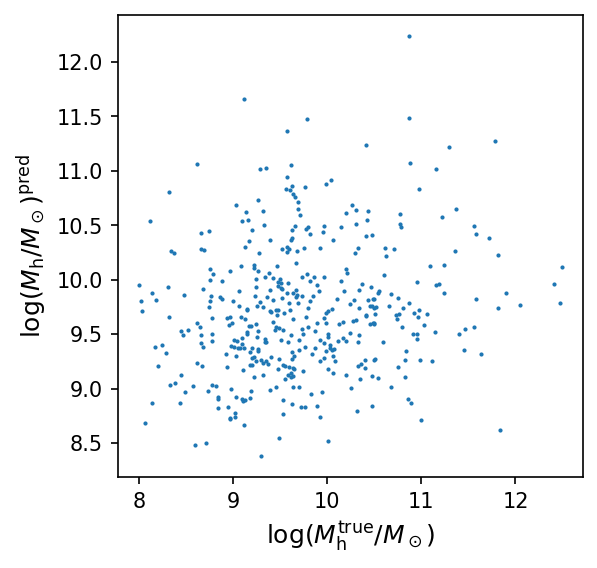

In [46]:
plt.figure(figsize=(4, 4), dpi=150)
plt.scatter(y_valid + 10 - h, p_valid + 10 - h, s=1)
plt.xlabel("$\\log(M_{\\rm h}^{\\rm true}/M_\\odot)$", fontsize=12)
plt.ylabel("$\\log(M_{\\rm h}/M_\\odot)^{\\rm pred}$", fontsize=12)

# Predict secondary halo parameter.

In [ ]:

config_params = dict(
    boxsize=51.7e3,    # box size in comoving kpc/h
    h_reduced=0.704,   # reduced Hubble constant
    snapshot=99,       # z = 0
)

normalization_params = dict(
    minimum_n_star_particles=10., # min star particles to be considered a galaxy
    norm_half_mass_radius=3., 
    norm_velocity=100., # note: use value of 1 if `use_central_galaxy_frame=True`
)

# predict outputs: M_acc_dyn, log_stellar_halo_mass_ratio, log_halo_mass, concentration, a50
science_params = dict(
    minimum_log_stellar_mass=7.5,   
    predict_output="vmax",
)

feature_params = dict(
    use_stellarhalfmassradius=True,
    use_velocity=True,
    use_only_positions=False,
    use_central_galaxy_frame=False, # otherwise use center of mass frame
    in_projection=True, # only use projected positions and radial velocity
)

training_params = dict(
    batch_size=256,
    learning_rate=1e-4,
    weight_decay=1e-5,
    n_epochs=200,
    valid_frac=0.15, 
    test_frac=0., 
)

model_params = dict(
    k_nn=100,
    n_layers=1,  
    n_hidden=128,
    n_latent=96,
    loop=False
)

experiment = science_params["predict_output"]

In [ ]:
df = load_data(
    tng_base_path=tng_base_path,
    snapshot=config_params["snapshot"], # default is 99 -> z=0 
    use_stellarhalfmassradius=feature_params["use_stellarhalfmassradius"],
    use_velocity=feature_params["use_velocity"],
    use_only_positions=feature_params["use_only_positions"],
    in_projection=feature_params["in_projection"],
    science_params=science_params
)

dataset, n_subhalos = generate_dataset(
    df,
    use_velocity=feature_params["use_velocity"],
    use_central_galaxy_frame=feature_params["use_central_galaxy_frame"],
    use_only_positions=feature_params["use_only_positions"],
    in_projection=feature_params["in_projection"],
    science_params=science_params
)
    
node_features = dataset[0].x.shape[1]
n_halos = len(dataset)

print("Number of features:", node_features)
print("Number of subhalos:", n_subhalos)
print("Number of halos:", n_halos)

NameError: name 'load_data' is not defined

In [ ]:
model = EdgePointGNN(
    node_features=node_features, 
    n_layers=model_params["n_layers"], 
    k_nn=model_params["k_nn"],
    hidden_channels=model_params["n_hidden"],
    latent_channels=model_params["n_latent"],
    loop=model_params["loop"]
)

model.to(device)

EdgePointGNN(
  (layers): ModuleList(
    (0): EdgePointLayer()
  )
  (fc): Sequential(
    (0): Linear(in_features=290, out_features=96, bias=True)
    (1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=96, out_features=96, bias=True)
    (4): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=96, out_features=2, bias=True)
  )
)

In [ ]:
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=training_params["learning_rate"], 
    weight_decay=training_params["weight_decay"]
)

In [ ]:
train_loader, valid_loader, test_loader = split_datasets(
    dataset,
    rng=rng,
    valid_frac=training_params["valid_frac"],
    test_frac=training_params["test_frac"],
    batch_size=training_params["batch_size"],
)

print("Number of training batches", len(train_loader))
print("Number of valication batches", len(valid_loader))
print("Number of test batches", len(test_loader))

Number of training batches 4
Number of valication batches 1
Number of test batches 0


In [ ]:
train_losses = []
valid_losses = []
for epoch in range(training_params["n_epochs"]):
    train_loss = train(train_loader, model, optimizer, device, in_projection=feature_params["in_projection"])
    valid_loss, valid_std, *_ = validate(valid_loader, model, device)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1: >3d}    train loss: {train_loss: >4.1f}     valid loss: {valid_loss: >4.1f}     average valid std: {np.mean(valid_std): >5.3f}")


Epoch  10    train loss: -9.8     valid loss: -9.5     average valid std: 0.182
Epoch  20    train loss: -11.1     valid loss: -10.6     average valid std: 0.146
Epoch  30    train loss: -11.9     valid loss: -11.0     average valid std: 0.125
Epoch  40    train loss: -12.3     valid loss: -11.2     average valid std: 0.114
Epoch  50    train loss: -12.3     valid loss: -11.1     average valid std: 0.101
Epoch  60    train loss: -12.7     valid loss: -11.2     average valid std: 0.098
Epoch  70    train loss: -12.9     valid loss: -11.7     average valid std: 0.094
Epoch  80    train loss: -13.5     valid loss: -12.0     average valid std: 0.091
Epoch  90    train loss: -12.9     valid loss: -11.8     average valid std: 0.086
Epoch 100    train loss: -12.9     valid loss: -12.1     average valid std: 0.082
Epoch 110    train loss: -13.2     valid loss: -12.1     average valid std: 0.080
Epoch 120    train loss: -13.4     valid loss: -12.1     average valid std: 0.078
Epoch 130    train

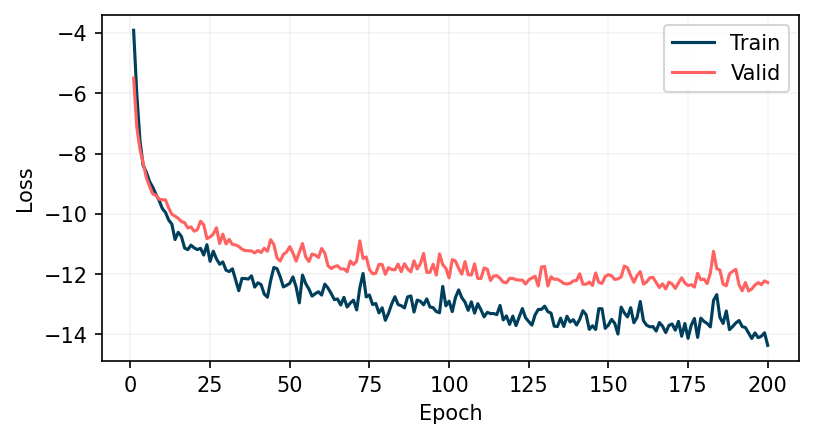

In [ ]:
plt.figure(figsize=(6, 3), dpi=150)
plt.plot(1 + np.arange(training_params["n_epochs"]), train_losses, c=c0, label="Train")
plt.plot(1 + np.arange(training_params["n_epochs"]), valid_losses, c=c3, label="Valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(alpha=0.15)

In [ ]:
valid_loss, valid_std, p_valid, y_valid, logvar_valid = validate(valid_loader, model, device)

print(f"Valid RMSE: {np.sqrt(np.mean((y_valid.flatten() - p_valid)**2)): >4.3f}")
print(f"Valid loss: {valid_loss: >4.3f}")
print(f"Valid std: {valid_std: >6.4f}")

Valid RMSE: 0.046
Valid loss: -12.281
Valid std: 0.0661


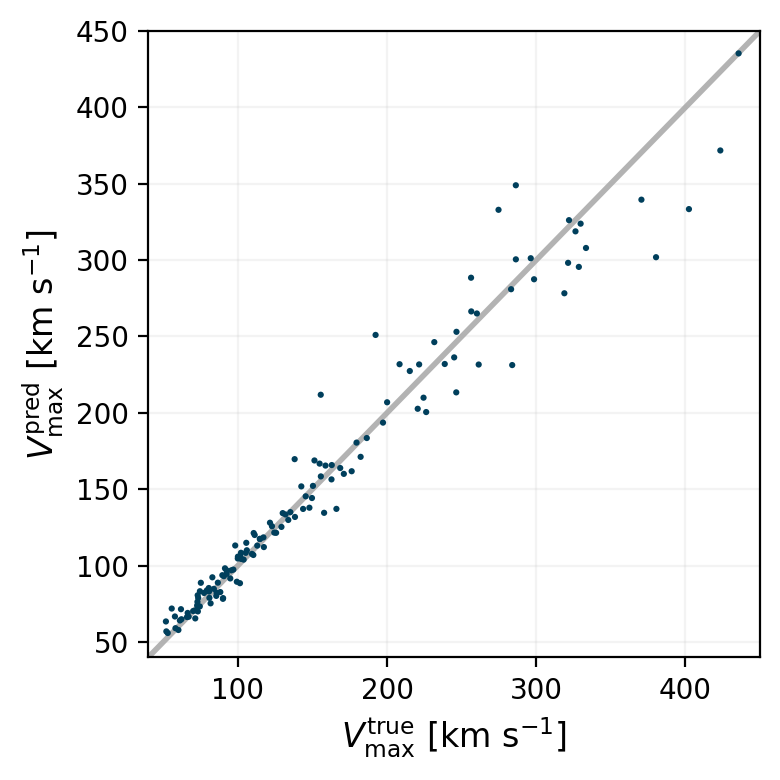

In [ ]:
plt.figure(figsize=(4, 4), dpi=200)

h = config_params["h_reduced"]
p = 10**p_valid * normalization_params["norm_velocity"]
y = 10**y_valid * normalization_params["norm_velocity"]

plt.scatter(y, p, s=5, edgecolors='none', c="#003f5c", zorder=3)

plt.xlabel("$V_{\\rm max}^{\\rm true}$ [km s$^{-1}$]", fontsize=12)
plt.ylabel("$V_{\\rm max}^{\\rm pred}$ [km s$^{-1}$]", fontsize=12)
plt.plot([0, 500], [0, 500], c='0.7', lw=2, zorder=1)

plt.xlim(40, 450)
plt.ylim(40, 450)
plt.tight_layout()
plt.grid(alpha=0.15)